In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.linalg import solve
import scipy
import scipy.integrate
from scipy.integrate import solve_ivp


class prettyfloat(float):
    def __repr__(self):
        return "%0.12f" % self

In [2]:
def f_modul(t,X, A, m, w, gamma): 
        return np.array([X[1] - 1 - m*np.cos(w*t) ,
                            (A - X[1]*(1 + np.exp(X[0])))*gamma])

Jacf_modul = lambda t,X,gamma: np.array([[0,1],
                                                [-gamma*X[1]*np.exp(X[0]),-gamma*(1+np.exp(X[0]))]])
s_modul = lambda t,X,A,m,w,gamma : X[1] - 1 - m
GradS_modul = lambda t,X,A,m,w,gamma: np.array([0,1])

s_modul2 = lambda t,X, A,m,w,gamma: gamma*(A - X[1]*(1+np.exp(X[0])))
GradS_modul2 = lambda t,X,A,m,w,gamma: np.array([-gamma*X[1]*np.exp(X[0]),-gamma*(1+np.exp(X[0]))])

ds_T_modul = lambda t,X: 0.0

In [3]:
def big_system(t, Y_M, f, Jacf, dim, A, m, w, gamma):
    # Solving numerically the initial value problem (dy/dt,dM/dt = (f(t,y),Gradf*M) 
    X_M = np.zeros((dim+dim**2),dtype=np.float64) #We solve simustanuously d+d*d ODEs to link up the solution and the monodromy matrix computation
    M = Y_M[dim:].reshape(dim, dim, order="F")  # Reshape the flat array back into a dim^2 x dim matrix
    dM_dt = Jacf(t,Y_M[:dim],gamma) @ M  # Compute the matrix derivative
    X_M[:dim] = f(t, Y_M[:dim],A,m,w,gamma)
    X_M[dim:] = dM_dt.flatten(order = "F")
    return X_M

In [55]:
def Newton_orbite_T_known(f, X_0,T,A, m, w, gamma, Jacf, Max_iter, epsilon):
    
    dim = np.shape(X_0)[0] #The problem's dimension

    #________________________________INITIALISATION_____________________________________
    k, Xstar_0 = 0, X_0
    sol = solve_ivp(fun=f,t_span=[0.0, T], y0=X_0, t_eval=[T],
                     method='DOP853', args = (A, m, w, gamma), option={"rtol": 1e-12,"atol":1e-14})
    G_Xstar_0 = sol.y[:,-1] - Xstar_0 #We take the solution at t=T
    #The complete rhd of the Newton system
    B = G_Xstar_0
    
    monodromy = np.eye(dim,dtype=np.float64) #Initialisation of the monodromy matrix

    X_by_iter , Norm_DeltaX= np.zeros((Max_iter+1,dim),dtype=np.float64),np.zeros((Max_iter+1),dtype=np.float64)
    X_by_iter[0,:] = Xstar_0
    Norm_DeltaX[0] = 1 # np.linalg.norm(B, ord=2)
    norm_delta_X =1
    #_____________Newton iteration loop____________________
    while (norm_delta_X> epsilon  and k<Max_iter):
        
        #- Solving numerically the initial value problem (dy/dt,dM/dt = (f(t,y),Gradf*M)
        X_M = np.zeros((dim+dim**2),dtype=np.float64) 

        # Flatten the monodromy to a 1D array, as solve_ivp needs a vector
        X_M[:dim] = Xstar_0
        X_M[dim:] = monodromy.flatten(order='F')
        #  Solve the system of ODEs
        big_sol= solve_ivp(big_system, [0.0,T], X_M,
                            t_eval=[T],
                            args=(f,Jacf,dim,A, m, w, gamma),
                            method='DOP853',option={"rtol": 1e-12,"atol":1e-14}) #It's a function of t
        
        X_M = big_sol.y[:,-1] #dimension d+d*d
        Xstar_T = X_M[:dim] # The solution at T
        monodromy = X_M[dim:] #We take M(T)
        monodromy = monodromy.reshape(dim,dim, order = "F") #Back to the square matrix format
        #______Computation of DeltaX and DeltaT_____
        #Concat the whole matrix
        Mat = monodromy - np.eye(dim,dtype=np.float64)
        
        #Right hand side concatenation
        G_Xstar_0 = Xstar_T - Xstar_0
        B = G_Xstar_0

        Delta_X = solve(Mat,-B) #Contain Delta_X and Delta_T
        # Delta_X = np.linalg.lstsq(Mat, -B, rcond=None)[0]
        print("Iteration", k)
        #print("Norm(Dx) = ", norm_delta_X,"\n")

        #Updating
        Xstar_0 = Delta_X + Xstar_0
        norm_delta_X = np.linalg.norm(Delta_X,ord=2)
        k = k+1
        X_by_iter[k,:] = Xstar_0
        Norm_DeltaX[k] = norm_delta_X
    # eigenvalues, eigenvectors = np.linalg.eig(monodromy)
    return k, X_by_iter, Norm_DeltaX, monodromy

In [91]:
Max_iter,epsilon = 100, 1e-13
A = 1.1
m = 2.5e-2*0.4
gamma = 1e-3
w = 1e-2
params = (A,m,w,gamma)
#L0, D0 = -5.878379158004416*(1. + 0e-1), 0.985996818660573 * (1. + 0e-2)#-np.log(A-1)+0.001, 1.005 #-5. ,1#0.9805 # m+1
L0,D0=-4.372747630234867,   0.9876596551775786
X0 = np.array([L0,D0])*(1. + 0e-2);
T0 = 2*np.pi/w

In [92]:
k, XX,Norm_DeltaX, M = Newton_orbite_T_known(f_modul, X0,T0, A, m, w, gamma, Jacf_modul, Max_iter, epsilon)


/home/evain/anaconda3/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `option`.
  warn("The following arguments have no effect for a chosen solver: {}."


Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

In [93]:


np.set_printoptions(precision=18)
print(XX[k])

k


[-4.372747630307559   0.9876596551775972]


100

## Ploting

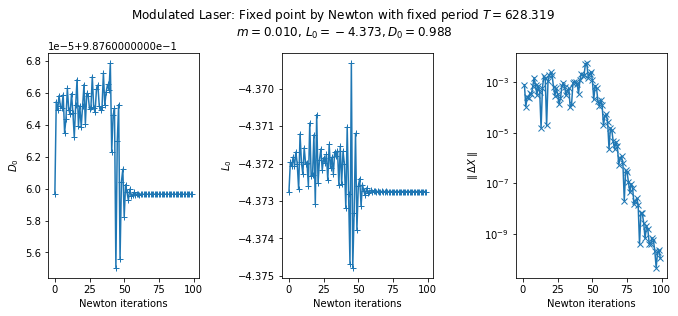

In [94]:
fig, ax = plt.subplots(1,3,sharex='all')
Tab = np.asarray(XX[:k])
ax[0].plot(np.arange(k),Tab[:,1],'+-')
ax[0].set_xlabel("Newton iterations")
ax[0].set_ylabel(f"$D_0$")

ax[1].plot(np.arange(k),Tab[:,0],'+-')
ax[1].set_xlabel("Newton iterations")
ax[1].set_ylabel(f"$L_0$")
ax[2].semilogy(np.arange(1,k),Norm_DeltaX[1:k],'x-')
ax[2].set_xlabel("Newton iterations")
ax[2].set_ylabel(f"$\parallel \Delta X \parallel$")
fig.set_size_inches((10,8))
fig.suptitle(f'Modulated Laser: Fixed point by Newton with fixed period $T=%.3f$ \n $m = %.3f$, $L_0 = %.3f, D_0= %.3f $' % (T0, m, L0,D0))
# fig.suptitle('(Rescaled approach Laser model :\n I0 = %.3f, D0 %.3f} )' % (I0,D0))

fig.subplots_adjust(left=0.09, bottom=0.51, right=0.95, top=0.90, hspace=0.55, wspace=0.55)
plt.savefig('./Results/Modulated_Laser_T_known.png')

## Solving the ODE with the found fixed point 

In [62]:
X0 = np.array(XX[k])
sol = solve_ivp(fun=f_modul,t_span=[0.0, 100*T0],
                t_eval=np.linspace(0.0,100*T0, 10000), 
                y0=X0, method='RK45', 
                args = params,vectorized=False,
                **{"rtol": 1e-10,"atol":1e-10}
                )

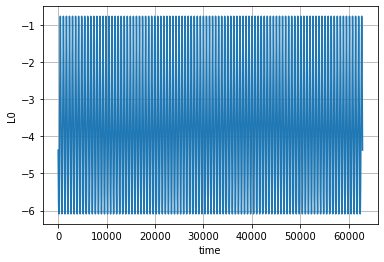

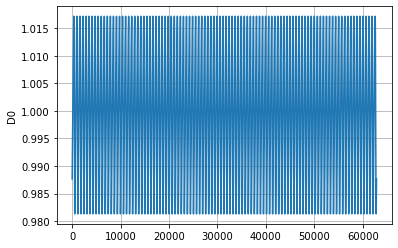

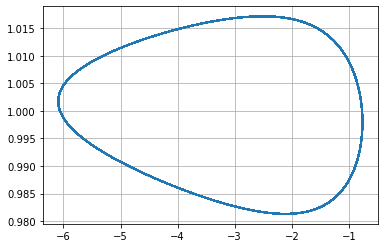

In [63]:
X = sol.y 
times_intervall = sol.t
plt.plot(times_intervall,X[0,:])
# plt.xlim([0,1100])
plt.grid()
plt.xlabel("time")
plt.ylabel("L0")
plt.show()

plt.plot(times_intervall,X[1,:])
plt.ylabel("D0")
plt.grid()
plt.show()

plt.plot(X[0,:], X[1,:])
plt.grid()
